# Notebook 9 - Diurnal Cycles of Clouds

This notebook will dive deeper into cloud frequency over topography throughout the day.

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import rasterio
from matplotlib.colors import LightSource
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.cm as cm

import warnings
warnings.filterwarnings("ignore")


/home/cdalden/miniforge3/envs/goes_env/lib/python3.13/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


In [2]:
# def hourly_cloud_freq_for_month(ds, hour):
#     # calculate the frequency of clouds for a specific hour for the month
#     hourly_clouds = ds.clouds.sel(
#                 t=(ds['t'].dt.hour == hour))
#     hourly_clouds_freq = (hourly_clouds/(len(hourly_clouds.t))).sum(dim='t')*100

#     return hourly_clouds_freq

def hourly_cloud_freq_for_month(ds, hours):
    """
    Calculate the frequency of clouds for a specific range of hours for the month.

    Parameters:
    - ds: xarray Dataset containing cloud data.
    - hours: List of hours to calculate the frequency for.

    Returns:
    - A dictionary where keys are hours and values are the cloud frequency for each hour.
    """
    combined_hourly_clouds = ds.clouds.sel(t=ds['t'].dt.hour.isin(hours))
    combined_clouds_freq = (combined_hourly_clouds / len(combined_hourly_clouds.t)).sum(dim='t') * 100

    return combined_clouds_freq

In [3]:
# May monthly cloud cover
path = '/storage/cdalden/goes/colorado/goes16/cloud_counts/'
file = 'goes16_cloud_frequency_colorado_202205.nc'
may_cloud_ds = xr.open_dataset(path + file)
# subset for faster processing
lon_min, lon_max = -107.75, -105.75
lat_min, lat_max = 38, 40
may_cloud_ds = may_cloud_ds.sel(latitude=slice(lat_max, lat_min), longitude=slice(lon_min, lon_max))

# July cloud cover
file = 'goes16_cloud_frequency_colorado_202207.nc'
july_cloud_ds = xr.open_dataset(path + file)
july_cloud_ds = july_cloud_ds.sel(latitude=slice(lat_max, lat_min), longitude=slice(lon_min, lon_max))

# August cloud cover
file = 'goes16_cloud_frequency_colorado_202208.nc'
august_cloud_ds = xr.open_dataset(path + file)
august_cloud_ds = august_cloud_ds.sel(latitude=slice(lat_max, lat_min), longitude=slice(lon_min, lon_max))


# morning clouds (8am to 10am MDT)
morning_hour_list = [14,15]
may_morning_cloud_freq = hourly_cloud_freq_for_month(may_cloud_ds, morning_hour_list)
july_morning_cloud_freq = hourly_cloud_freq_for_month(july_cloud_ds, morning_hour_list)
august_morning_cloud_freq = hourly_cloud_freq_for_month(august_cloud_ds, morning_hour_list)

# afternoon clouds (1pm to 6pm MDT)
afternoon_hour_list = [19,20,21,22,23]
may_afternoon_cloud_freq = hourly_cloud_freq_for_month(may_cloud_ds, afternoon_hour_list)
july_afternoon_cloud_freq = hourly_cloud_freq_for_month(july_cloud_ds, afternoon_hour_list)
august_afternoon_cloud_freq = hourly_cloud_freq_for_month(august_cloud_ds, afternoon_hour_list)

In [4]:
# Path to the DEM file
dem_path = "colorado_dem.tif"

# Open the DEM file
with rasterio.open(dem_path) as src:
    elevation = src.read(1)  # Read the first band (elevation data)
    bounds = src.bounds      # Get the bounds of the DEM
    extent = [bounds.left, bounds.right, bounds.bottom, bounds.top]

# for plotting dem
# Generate terrain shading
ls = LightSource(azdeg=315, altdeg=45)  # Azimuth and altitude of the light source
shaded = ls.shade(elevation, cmap=cm.get_cmap("Greys"), vert_exag=1, blend_mode="overlay")



In [5]:
def plot_features(ax, label_color):
    '''
    Add random objects to maps to better understand geography

    ax: axis to plot on (axes obj, 'ax1)
    label_color: specify label color depending on how dark the plot is (str, 'white')
    '''

    ax.set_extent([-107.5, -106.5, 38.4, 39.4], crs=ccrs.PlateCarree())  # east riverish extent

    # Add gridlines with latitude and longitude labels
    gridlines = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.7, linestyle='--')
    gridlines.top_labels = False  # Disable top labels
    gridlines.right_labels = False  # Disable right labels
    gridlines.xlabel_style = {'size': 10, 'color': 'black'}
    gridlines.ylabel_style = {'size': 10, 'color': 'black'}

    # Add towns
    ax.plot(-106.9886, 38.958, color=label_color, marker='o', label='Gothic')
    ax.text(-106.9736, 38.958, 'Gothic', fontsize=10, ha='left', color=label_color)

    ax.plot(-106.984, 38.87, color=label_color, marker='o', label='CB')
    ax.text(-106.969, 38.87, 'CB', fontsize=10, ha='left', color=label_color)

    ax.plot(-106.926, 38.545, color=label_color, marker='o', label='Gunnison')
    ax.text(-106.931, 38.565, 'Gunnison', fontsize=10, ha='left', color=label_color)

    ax.plot(-106.822, 39.19, color=label_color, marker='o', label='Aspen')
    ax.text(-106.807, 39.19, 'Aspen', fontsize=10, ha='left', color=label_color)

    # Add peaks
    ax.plot(-107.199, 38.718, color=label_color, marker='^', label='West Elk')
    ax.text(-107.184, 38.718, 'West Elk', fontsize=10, ha='left', color=label_color)

    ax.plot(-106.989, 39.071, color=label_color, marker='^', label='Maroon Pk')
    ax.text(-106.974, 39.071, 'Maroon Pk', fontsize=10, ha='left', color=label_color)

    ax.plot(-107.281, 39.037, color=label_color, marker='^', label='Ragged Pk')
    ax.text(-107.266, 39.037, 'Ragged Pk', fontsize=10, ha='left', color=label_color)

    ax.plot(-107.383, 38.812, color=label_color, marker='^', label='Mt. Gunnison')
    ax.text(-107.368, 38.812, 'Mt. Gunnison', fontsize=10, ha='left', color=label_color)

    roads = cfeature.NaturalEarthFeature(category='cultural', name='roads', scale='10m', facecolor='none')
    ax.add_feature(roads, edgecolor='black', linewidth=0.5)

    # ax.legend()

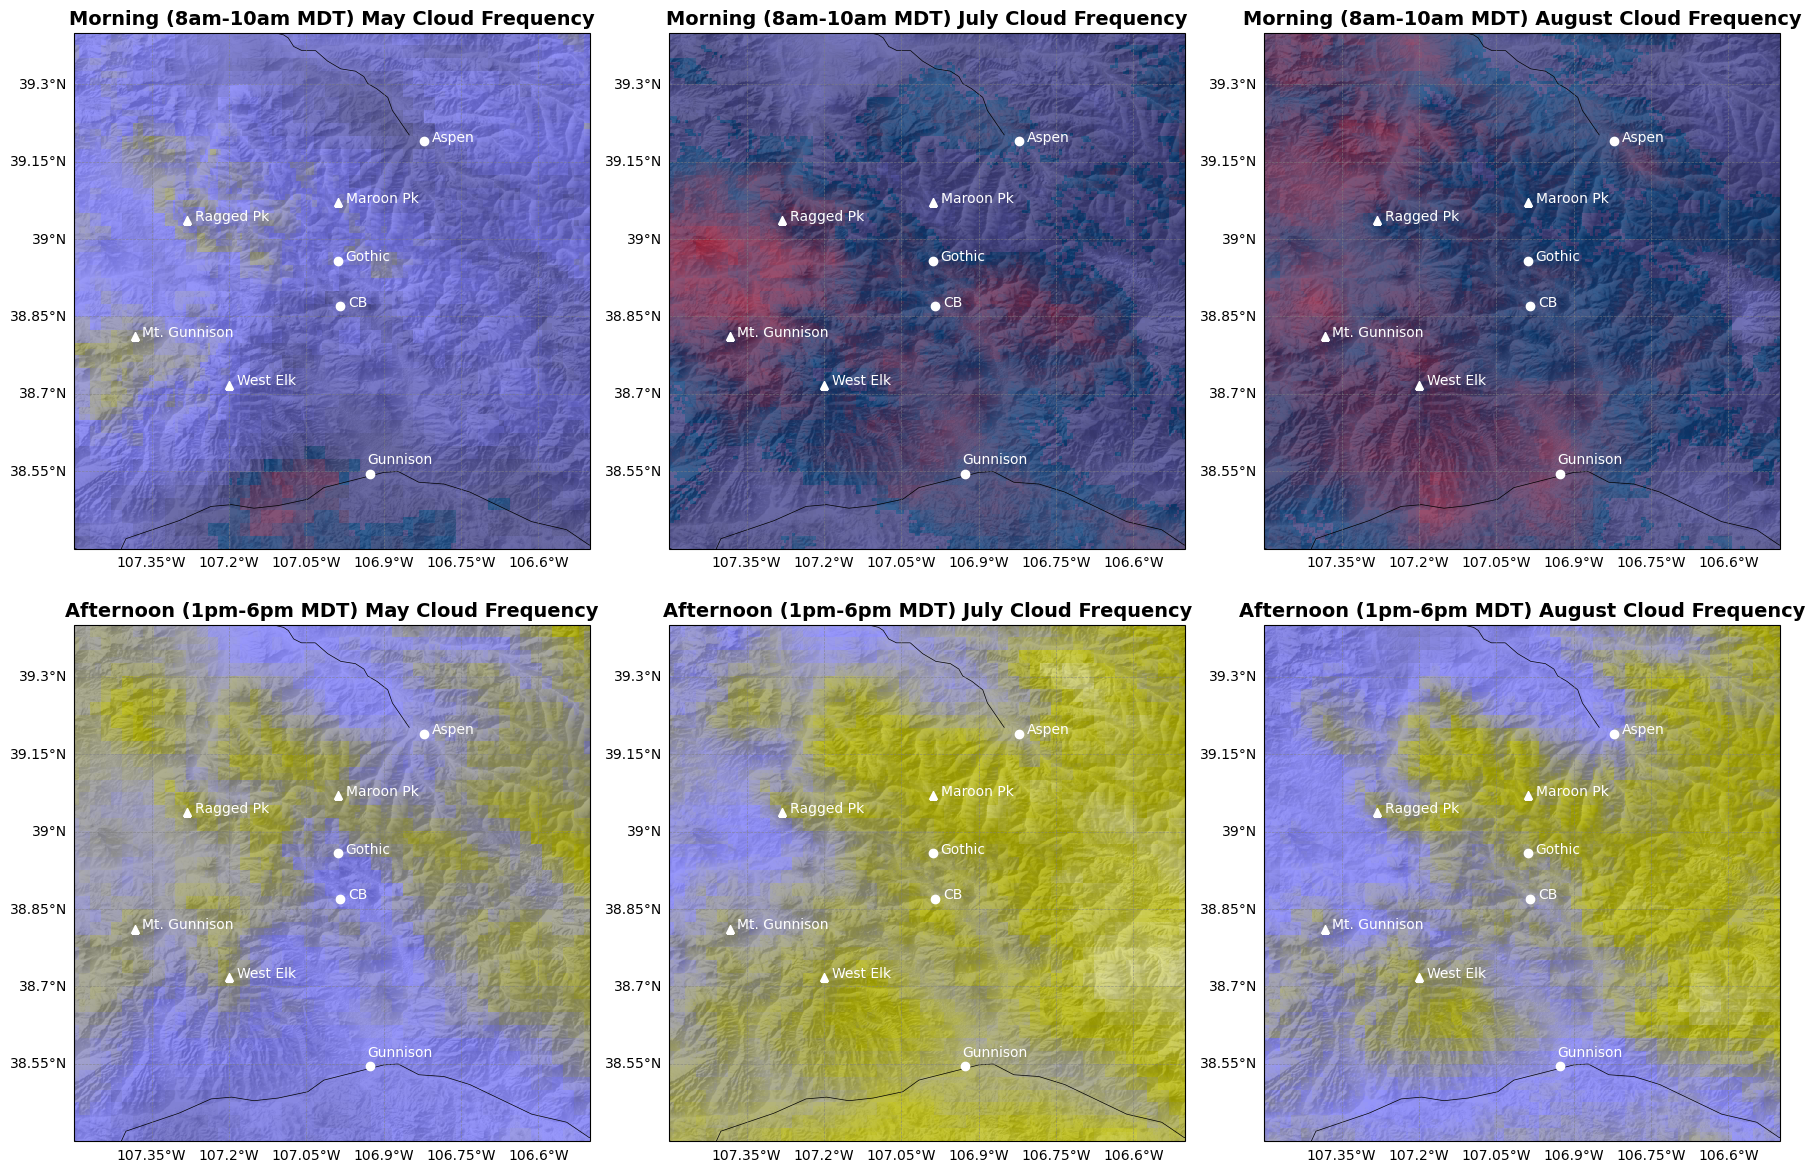

In [6]:
# Create the figure and subplots with Cartopy projection
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 12), subplot_kw={'projection': ccrs.PlateCarree()})

# Define the colormap and normalization for consistent scaling
cmap = 'gist_stern'
vmin, vmax = 0, 80

# Plot May Morning Cloud Frequency on the top-left subplot
im = may_morning_cloud_freq.plot.imshow(ax=axes[0, 0], cmap=cmap, add_colorbar=False, vmin=vmin, vmax=vmax)
axes[0, 0].imshow(shaded, extent=extent, transform=ccrs.PlateCarree(), origin="upper", alpha=0.2)
plot_features(axes[0, 0], 'white')
axes[0, 0].set_title('Morning (8am-10am MDT) May Cloud Frequency', fontweight='bold', fontsize=14)

# Plot May Afternoon Cloud Frequency on the top-right subplot
may_afternoon_cloud_freq.plot.imshow(ax=axes[1, 0], cmap=cmap, add_colorbar=False, vmin=vmin, vmax=vmax)
axes[1, 0].imshow(shaded, extent=extent, transform=ccrs.PlateCarree(), origin="upper", alpha=0.2)
plot_features(axes[1, 0], 'white')
axes[1, 0].set_title('Afternoon (1pm-6pm MDT) May Cloud Frequency', fontweight='bold', fontsize=14)

# Plot July Morning Cloud Frequency on the bottom-left subplot
july_morning_cloud_freq.plot.imshow(ax=axes[0, 1], cmap=cmap, add_colorbar=False, vmin=vmin, vmax=vmax)
axes[0, 1].imshow(shaded, extent=extent, transform=ccrs.PlateCarree(), origin="upper", alpha=0.2)
plot_features(axes[0, 1], 'white')
axes[0, 1].set_title('Morning (8am-10am MDT) July Cloud Frequency', fontweight='bold', fontsize=14)

# Plot July Afternoon Cloud Frequency on the bottom-right subplot
july_afternoon_cloud_freq.plot.imshow(ax=axes[1, 1], cmap=cmap, add_colorbar=False, vmin=vmin, vmax=vmax)
axes[1, 1].imshow(shaded, extent=extent, transform=ccrs.PlateCarree(), origin="upper", alpha=0.2)
plot_features(axes[1, 1], 'white')
axes[1, 1].set_title('Afternoon (1pm-6pm MDT) July Cloud Frequency', fontweight='bold', fontsize=14)

# Plot August Morning Cloud Frequency on the bottom-left subplot
august_morning_cloud_freq.plot.imshow(ax=axes[0, 2], cmap=cmap, add_colorbar=False, vmin=vmin, vmax=vmax)
axes[0, 2].imshow(shaded, extent=extent, transform=ccrs.PlateCarree(), origin="upper", alpha=0.2)
plot_features(axes[0, 2], 'white')
axes[0, 2].set_title('Morning (8am-10am MDT) August Cloud Frequency', fontweight='bold', fontsize=14)

# Plot August Afternoon Cloud Frequency on the bottom-right subplot
august_afternoon_cloud_freq.plot.imshow(ax=axes[1, 2], cmap=cmap, add_colorbar=False, vmin=vmin, vmax=vmax)
axes[1, 2].imshow(shaded, extent=extent, transform=ccrs.PlateCarree(), origin="upper", alpha=0.2)
plot_features(axes[1, 2], 'white')
axes[1, 2].set_title('Afternoon (1pm-6pm MDT) August Cloud Frequency', fontweight='bold', fontsize=14)

# # Add a single colorbar to the right of all subplots
# cbar = fig.colorbar(im, ax=axes, orientation='vertical', location='right', fraction=0.02, pad=0.05)
# cbar.set_label('Cloud Frequency (%)', fontsize=14, fontweight='bold')

# Adjust layout for better spacing
plt.tight_layout()

## Compare cloud frequency for different months at the same time of day

In [7]:
may_july_dif_afternoon_cloud_freq = may_afternoon_cloud_freq - july_afternoon_cloud_freq
may_july_dif_morning_cloud_freq = may_morning_cloud_freq - july_morning_cloud_freq

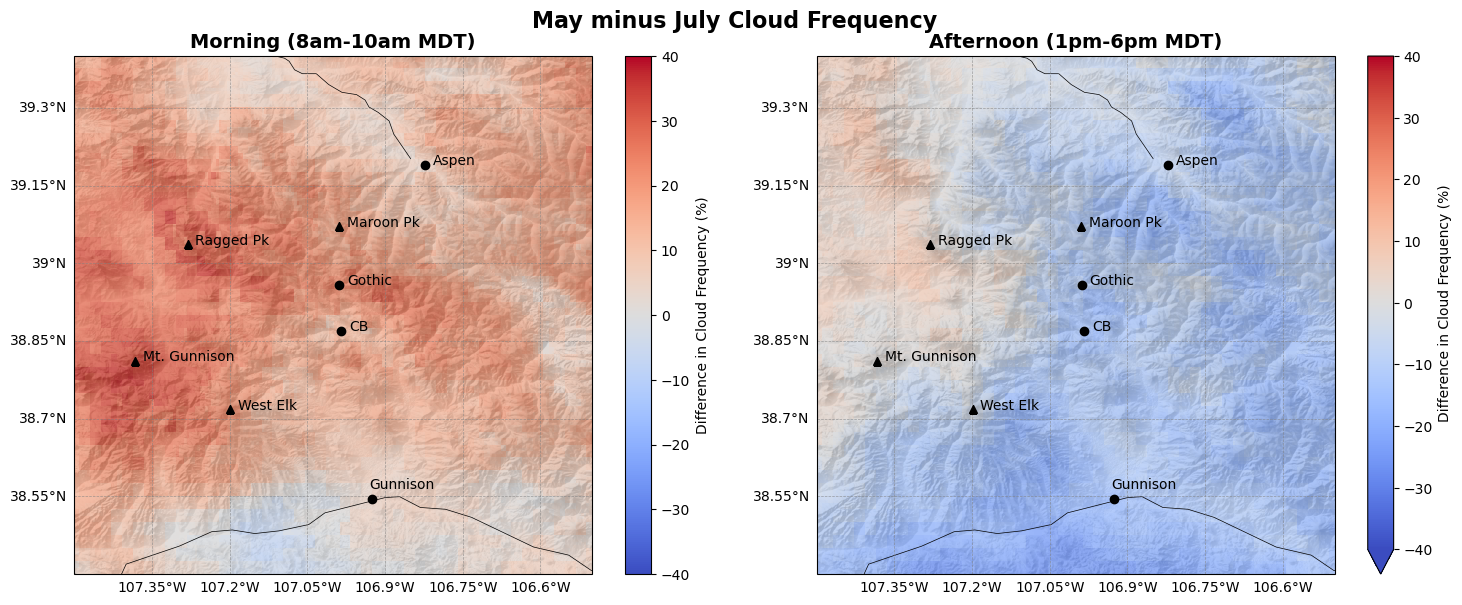

In [8]:
# Create the figure and subplots with Cartopy projection
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 6), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the morning frequency difference on the left subplot
may_july_dif_morning_cloud_freq.plot.imshow(ax=ax1, cmap='coolwarm', cbar_kwargs={'label': 'Difference in Cloud Frequency (%)'}, vmin=-40, vmax=40)
ax1.imshow(shaded, extent=extent, transform=ccrs.PlateCarree(), origin="upper", alpha=0.2)
plot_features(ax1, 'black')
ax1.set_title('Morning (8am-10am MDT)', fontweight='bold', fontsize=14)

# Plot the afternoon frequency difference on the right subplot
may_july_dif_afternoon_cloud_freq.plot.imshow(ax=ax2, cmap='coolwarm', cbar_kwargs={'label': 'Difference in Cloud Frequency (%)'}, vmin=-40, vmax=40)
ax2.imshow(shaded, extent=extent, transform=ccrs.PlateCarree(), origin="upper", alpha=0.2)
plot_features(ax2, 'black')
ax2.set_title('Afternoon (1pm-6pm MDT)', fontweight='bold', fontsize=14)

plt.suptitle('May minus July Cloud Frequency', fontweight='bold', fontsize=16)

# Adjust layout for better spacing
plt.tight_layout()
